<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/ContrastAndColor/Amplitude_jumps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Study of the distribution of amplitude jumps in a digital image

The purpose of this practical session is to model the distribution of amplitude jumps in images. This session is directly inspired from a homework subject created by Yann Gousseau.

**Authors:**
* [Julie Delon](https://github.com/judelo)
* Lucía Bouza

## Importing packages

Below is a list of packages required in the notebook:

- `numpy`
- `matplotlib` (display of images and graphics)
-  `os` (interactions with the operating system)
- `scipy` (additional tools for array computing)
- `qqplot_2samples` (comparision of quantiles)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm, kurtosis
from scipy.special import gamma, gammainc, gammaincinv, psi
from statsmodels.graphics.gofplots import qqplot_2samples

To import the solutions, execute the following cell. If you are using a Windows system, comment the `os.system` line, download the file by hand, and place it in the same folder as the notebook.

In [2]:
#os.system("wget -nc https://raw.githubusercontent.com/storimaging/Notebooks/main/ContrastAndColor/Solutions/Amplitude_jumps.py")
#from Amplitude_jumps import *

## Load and display images

A color image is made of three channels: red, green and blue. A color image in $\mathbb{R}^{N\times M}$ is stored as a $N\times M\times 3$ matrix.

    
**Be careful with the functions `plt.imread()` and `plt.imshow()` of `matplotlib`.** 
- `plt.imread()` reads png images as numpy arrays of floating points between 0 and 1, but it reads jpg or bmp images as numpy arrays of 8 bit integers. 

- In this practical session, we assume images are encoded as floating point values between 0 and 1, so if you load a jpg or bmp file you must convert the image to float type and normalize its values to $[0,1]$.

- If 'im' is an image encoded as a float numpy array, `plt.imshow(im)` will do a linear scaling, mapping the lowest value to 0 (black) and the highest to 1 (white). If the 'im' image is 8-bit encoded, `plt.imshow(im)` will display 0 in black and 255 in white.

In [3]:
os.system("wget -c https://raw.githubusercontent.com/storimaging/Images/main/img/parrot.png")
imrgb = plt.imread("parrot.png")

Display the image size.

In [4]:
[nrow,ncol,nch]=imrgb.shape
print(nrow,ncol,nch)

495 495 3


You can use `plt.imshow()` to display the 3D numpy array `imrgb` as an image. 

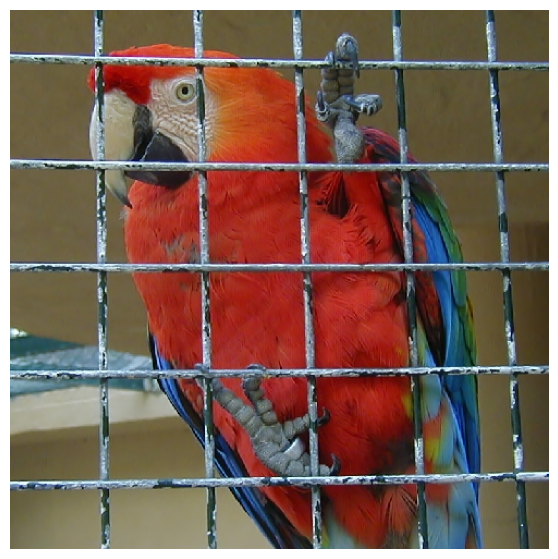

In [6]:
plt.figure(figsize=(7, 7))
plt.imshow(imrgb)
plt.axis('off')
plt.show()

It might be useful to convert the color image to gray levels. This can be done by averaging the three channels, or by computing another well chosen linear combination of the coordinates R, G and B. 

We use a custom weighted averaging of the three channels, that reflects well human perception:
$$u_{gs}=0.21r+0.72g+0.07b$$

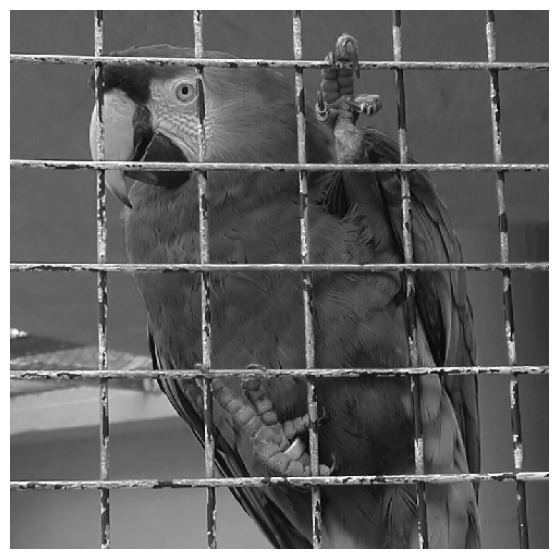

In [7]:
imgray2 = 0.21*imrgb[:,:,0] + 0.72*imrgb[:,:,1] + 0.07*imrgb[:,:,2]
# you can also do: imgray2 = np.average(imrgb,axis=2,weights=[0.21,0.71,0.07])
plt.figure(figsize=(7, 7))
plt.imshow(imgray2,cmap='gray',vmin=0,vmax=1)
plt.axis('off')
plt.show()

## Amplitude jumps

We call horizontal amplitude jumps the quantities $h(i, j) = u(i, j + 1) − u(i, j)$, and vertical jumps the quantities $v(i, j) = u(i+1 , j)−u(i, j)$. To get the first ones, type for example:

In [8]:
h = imgray2[:,1:-1]- imgray2[:,0:-2]

A strong discontinuity in the image creates a large response, while an homogeneous area yields small responses (in absolute value). We wish to study the empirical distribution of these jumps. For instance, in the horizontal case, we see each $h(i,j)$ as a realization of a random variable $H_{i,j}$, and we assume that the $H_{i,j}$ are identically distributed. We will also assume  that the $H_{i,j}$ are independent (which is clearly false, it would be true by taking only one pixel out of 2 in each direction). We note $X$ the associated random variable, and $X_k$ the reordering of the variables $H_{i,j}$ in the form of a random vector with $P = MN$ elements. This is done by the `reshape` command.

Start by visualizing the image of the amplitude jumps, then the histogram associated with the variable $X$. The goal of the following sections is to fit a parametric distribution on this empirical distribution of amplitude jumps. Do you have an idea of which kind of distribution would be adequate? 

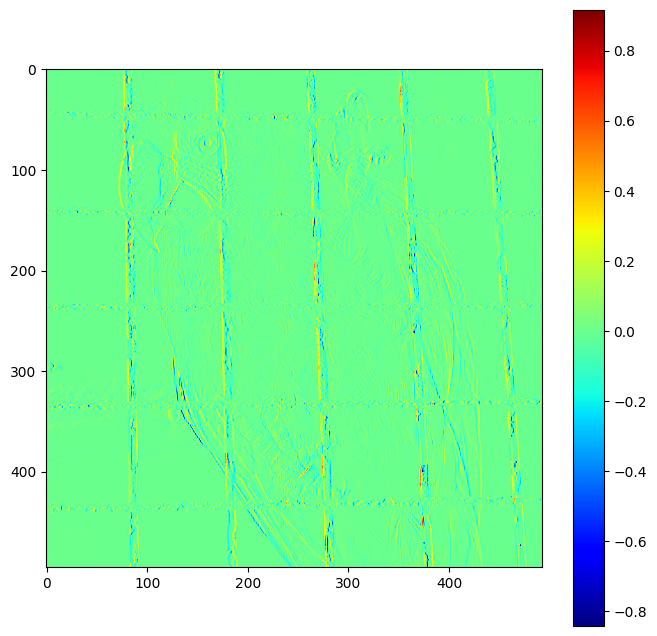

In [9]:
# Image of horizontal amplitude jumps
plt.figure(figsize=(8, 8))
im = plt.imshow(h)
plt.jet()
plt.colorbar(im)
plt.show()

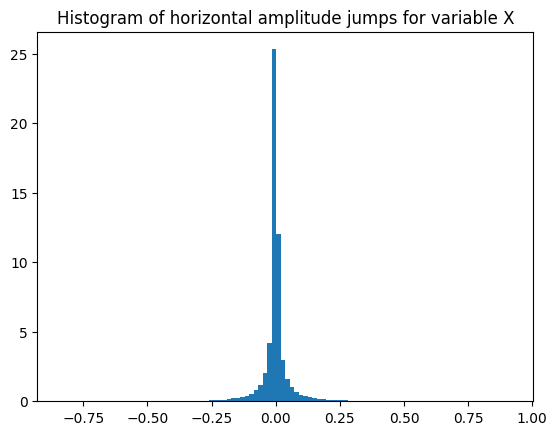

In [10]:
# Histogram of horizontal amplitude jumps X
X = np.reshape(h, h.shape[0]*h.shape[1])
plt.hist(X,100,density=True)
plt.title('Histogram of horizontal amplitude jumps for variable X')
plt.show()

## Modeling by a Gaussian



### Comparison of histograms

For the sake of simplicity, we first assume that the density of the variable X follows a Gaussian law:

$$
g(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\mathrm{exp}\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
$$


Recall the expressions of the associated empirical mean and variance:

$$
\hat{\mu} = \frac{1}{P}\sum_{k=1}^{P}X_k,
$$

$$
\hat{\sigma}^2 = \frac{1}{P}\sum_{k=1}^{P}(X_k - \hat{\mu})^2
$$

Estimate the mean and standard deviation on your data (`np.mean` and `np.std` functions). Compare the density of the Gaussian associated with the histogram of the jumps. Do they fit well?

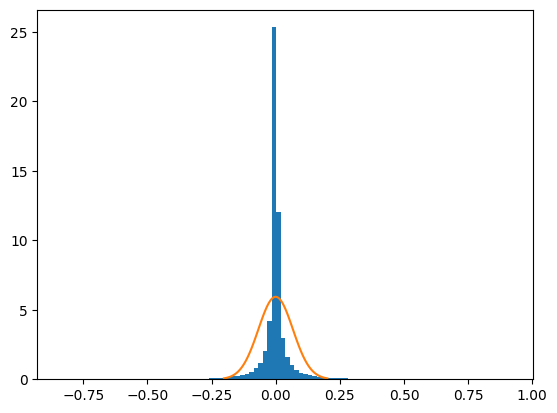

In [11]:
mu = np.mean(X)
sigma = np.std(X)

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.hist(X, 100, density=True)
plt.plot(x, norm.pdf(x, mu, sigma))
plt.show()

### Comparison of quantiles

In order to decide if the two distributions fit, we will use quantiles. The quantile of order $p$ of a real random variable $X$ is the real $t$ (if it's uniquely defined) such that 

$P\{X \le t\} =p$. 

For a vector $y$ of length $n$, the quantile of order $p \in (0, 1)$ of $y$ is the value placed in the (normalized) position $p$ in a sorted copy $h$ of $y$. If $p$ falls between two normalized positions $k/n$ and $(k+1)/n$, then the quantile of order $p$ is a weighted mean between $h(k)$ and $h(k+1)$ with respective weights $p-k$ and $k+1−p$.

Quantiles allow us to judge how a variable is distributed.The comparison of the quantiles associated with two observations makes it possible to judge the similarity of the laws of the associated random variables.

The function `np.quantile` allows us to calculate the $p^{i_{th}}$ quantile of a data vector. This function accepts a vector of values for $p$ in which case the output is the corresponding vector $q$. Run the quantile function on the data and the vector `p=np.arange(0, 100)/100`.

In [12]:
p_values = np.arange(0, 100)/100
quantile = np.quantile(X, p_values)

We can check that if we plot the quantiles of a Gaussian variable $N(\mu_1,\sigma_1)$ as a function of the quantiles of another Gaussian variable $N(\mu_2,\sigma_2)$, we obtain a straight line. Define a function `CompareQuantiles` to plot the quantiles of the two variables against each other. 

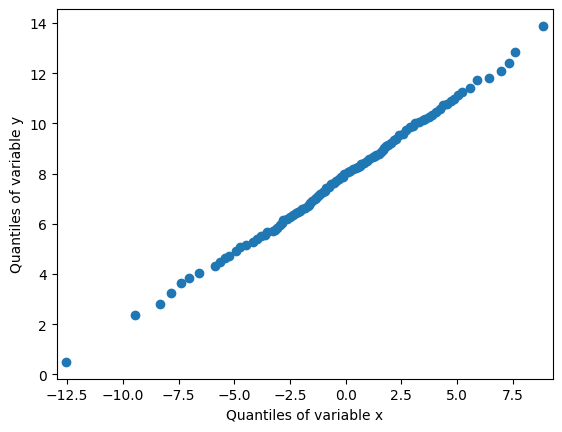

In [13]:
# Choose mean and standard deviations of Gaussian variables
mu1, sigma1, mu2, sigma2 = 0.0, 4.0, 8.0, 2.5

# Draw realizations of these two Gaussian variables  
x_var = np.random.normal(loc=mu1, scale=sigma1, size =1000)
y_var = np.random.normal(loc=mu2, scale=sigma2, size =1000)

# Plot Quantile-Quantile function
CompareQuantiles(x_var,y_var, p_values, "Quantiles of variable x", "Quantiles of variable y")
# you can also do 
# plt.scatter(np.sort(y_var),np.sort(x_var))
# since both vectors have the same size

What if you plot the quantiles associated with your horizontal jumps observations as a function of those associated with the Gaussian $N(0,1)$? Explain what you observe, compare to the first histogram comparison.

We will assume that the variable $X$ is centered, and we will therefore be interested in $X_k − \hat\mu$.

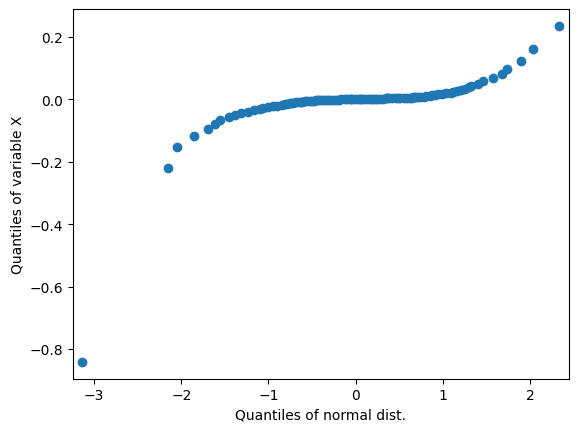

In [14]:
X = X - mu
norm_dist = np.random.normal(size =1000)
CompareQuantiles(norm_dist, X, p_values, "Quantiles of normal dist.", "Quantiles of variable X")

## Modeling by a “generalized Laplacian” law

In this section we propose to model the law of $X$ by a generalized Laplacian, whose density is

$$
f_{\alpha, \eta}(x) = C(\alpha, \eta) \mathrm{exp}(−|\eta x|α) ,
$$

with $\eta > 0$, $α > 0$ and $C(\alpha, \eta) = \frac{\alpha\eta}{2}\Gamma (\alpha^{-1})^{-1} $.

### Estimation by the method of moments

It is known that for such law, the variance and kurtosis are respectively given by

$$
\sigma^2 = \frac{\Gamma\left( \frac{3}{\alpha}\right)}{\eta^2 \Gamma\left( \frac{1}{\alpha}\right)}
$$

and
$$
\kappa = \frac{\Gamma \left( \frac{1}{\alpha}\right) \Gamma \left( \frac{5}{\alpha} \right)}{ \Gamma \left( \frac{3}{\alpha}\right) ^2 }.
$$

We propose to use the method of moments to estimate the values $\tilde{\alpha}$ and $\tilde{\eta}$ associated with the observations $X$. Start by plotting the function $\kappa$ as a function of $\alpha$ (use the function `gamma` of `scipy.stats`).  

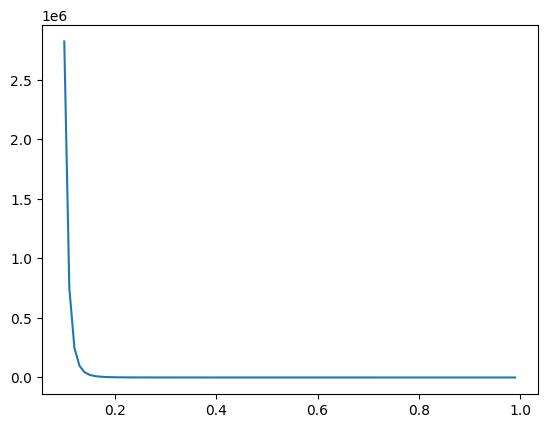

In [15]:
# plotting the kappa function as a function of alpha 
alphas= np.arange(0.1,1,0.01)
k = [equation2(alpha) for alpha in alphas]
plt.plot(alphas, k)

Then estimate the empirical kurtosis on your observations, $\hat{\kappa}$, using the `kurtosis` function of `scipy.stats`. Solve the equation $\kappa(\alpha) = \hat{\kappa}$ by tabulating the values of $\kappa$ as a function of $\alpha$. Once an estimate of $\alpha$, $\hat{\alpha}$ is found, use the first equation  to find an estimate $\hat{\eta}$ of the parameter $\eta$.

In [16]:
# empirical std and kurtosis
sigma = np.std(X)
k_hat=kurtosis(X)
print("k_hat = ", k_hat)

# estimate alpha
alpha_hat = findAlpha(k, k_hat, alphas)
print("alpha_hat = ", alpha_hat)

# estimate eta
eta_hat = np.sqrt(equation1(sigma, alpha_hat))
print("eta_hat = ", eta_hat)

k_hat =  25.175024120063796
alpha_hat =  0.4999999999999998
eta_hat =  162.98932412112177


Compare the density of the obtained distribution, $f_{\hat{\alpha},\hat{\eta}}$ with the histogram of your observations. What do you think?

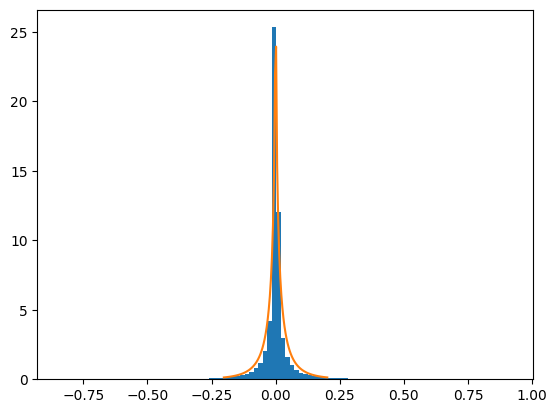

In [17]:
# plot density of the obtained distribution
plt.hist(X, 100, density=True)
f = [distribution_f(i, alpha_hat, eta_hat) for i in x]
plt.plot(x, f)
plt.show()

Now, we will compare the empirical quantiles associated with the observations to those associated with realizations of a variable according to the generalized Laplacian law. In order to draw samples for the generalized Laplace law, we can use the fact that for a uniform random variable $U$ on $[0,1]$, if $F_{\alpha,\eta}$ 
is the cumulative  distribution function of $f_{\alpha, \eta}$, then $F_{\alpha,\eta}^{-1}(U)$ follow the distribution of density  $f_{\alpha, \eta}$.
Now, we can easily check (do the computation) that 
$$F_{\alpha, \eta}(x) = \int_{-\infty}^x f_{\alpha, \eta}(t)dt = \frac 1 2 (1+ sign(x) \Gamma_{inc}(\frac 1 \alpha, (\eta |x|)^{\alpha}), $$
where $\Gamma_{inc}$ is the regularized lower incomplete Gamma function, defined as  
$$\Gamma_{inc}(a, x) = \frac{1}{\Gamma(a)} \int_0^x t^{a - 1}e^{-t} dt.$$  
It follows that $F_{\alpha, \eta}^{-1}$ can be written as a function of $\Gamma_{inc}^{-1}$, which happens to be a function of 'scipy' called 'gammaincinv'.
Again, simple computations (that you shoud do as an exercise) yield 
$$F_{\alpha, \eta}^{-1}(x) = sign(2x-1)*\frac 1 \eta (\Gamma_{inc}^{-1}(\frac 1 \alpha,|2*x-1|))^{1/\alpha}.$$

Plot the empirical quantiles of the horizontal jumps $X$ as a function of those of the generalized Laplace $f_{\hat{\alpha},\hat{\eta}}$. What do you observe?

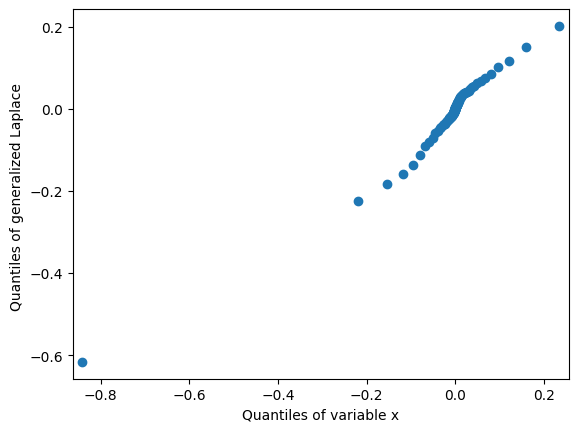

In [18]:
U = np.random.rand(1000,)

def Finv(alpha,eta,y):
  if y >= 0.5:
    return 1/eta*gammaincinv(1/alpha,2*y-1)**(1/alpha)
  else:
    return -1/eta*gammaincinv(1/alpha,2*(1-y)-1)**(1/alpha)


y_var = [Finv(alpha_hat,eta_hat,u) for u in U]

# Plot Quantile-Quantile function
CompareQuantiles(X,y_var, p_values, "Quantiles of variable x", "Quantiles of generalized Laplace ")

### Optional question: maximum likelihood estimation

Maximize the likelihood associated with your data as a function of $\alpha$ and $\eta$, to find the estimates $\tilde{\alpha}$ and $\tilde{\eta}$ (we can use the `scipy.special.psi` function, approximation of the derivative of the logarithm of the gamma function). To do this, use a relation between $\tilde{\alpha}$ and $\tilde{\eta}.$ Compare with the method of moments.

Observe that for observations $\{x_i\}_{i=1,\dots,n}$, minus the log-likelihood is
$$ L(x_1,\dots,x_n) = -n \log C(\alpha,\eta) + \sum_i |\eta x_i|^{\alpha}.$$
Derivating with respects to $\eta$ yields
$$\frac{\partial L}{\partial \eta} = -\frac n \eta + \sum_i \alpha \eta^{\alpha -1} |x_i|^{\alpha}$$
and derivating with respect to $\alpha$ yields
$$\frac{\partial L}{\partial \alpha} = -\frac n \alpha -\frac n {{\alpha}^2} \psi(\frac 1 \alpha) +\sum_i \log(\eta |x_i|)   |\eta x_i|^{\alpha}.$$
The first derivative is zero iff $$\hat{\eta} = (\frac n {\sum \alpha |x_i|^{\alpha}})^{1/\alpha}.$$ 


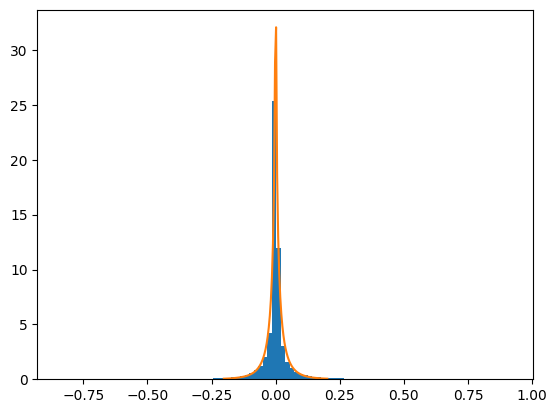

In [19]:
eta_hat2 = (np.size(X)/(np.sum(alpha_hat*np.abs(X)**alpha_hat)))**(1/alpha_hat)
plt.hist(X, 100, density=True)
f = [distribution_f(i, alpha_hat, eta_hat2) for i in x]
plt.plot(x, f)
plt.show()

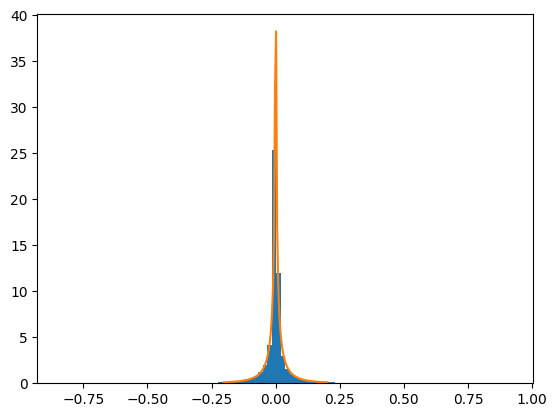

alpha_hat =  0.30927850767150117
eta_hat =  3632.146637534445


In [20]:
alpha_MLL, eta_MLL = Estimation_MaxLikelihood(X, epsilon = 0.01)

# plot density of the obtained distribution
plt.hist(X, 100, density=True)
f = [distribution_f(i, alpha_MLL, eta_MLL) for i in x]
plt.plot(x, f)
plt.show()

print("alpha_hat = ", alpha_MLL)
print("eta_hat = ", eta_MLL)